In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

from scipy.stats import spearmanr

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

In [2]:
df_train = pd.read_csv('mushroom_train.csv')
y_train = df_train['class']
y_train = y_train.replace({'p': 1, 'e': 0})
X_train_cat = df_train.drop('class', axis=1)

df_test = pd.read_csv('mushroom_test.csv')
y_test = df_test['class']
y_test = y_test.replace({'p': 1, 'e': 0})
X_test_cat = df_test.drop('class', axis=1)

# Label encoding
le = LabelEncoder()
X_train = X_train_cat.apply(le.fit_transform)
X_test = X_test_cat.apply(le.fit_transform)

In [3]:
edible = df_train[df_train['class'] == 'e']
poisonous = df_train[df_train['class'] == 'p']

feature_col = df_train.columns[1:]
num_col = ['stem-height', 'stem-width']
feature_col_cat = feature_col.drop(num_col)
feature_col_cat = feature_col_cat.drop('class')


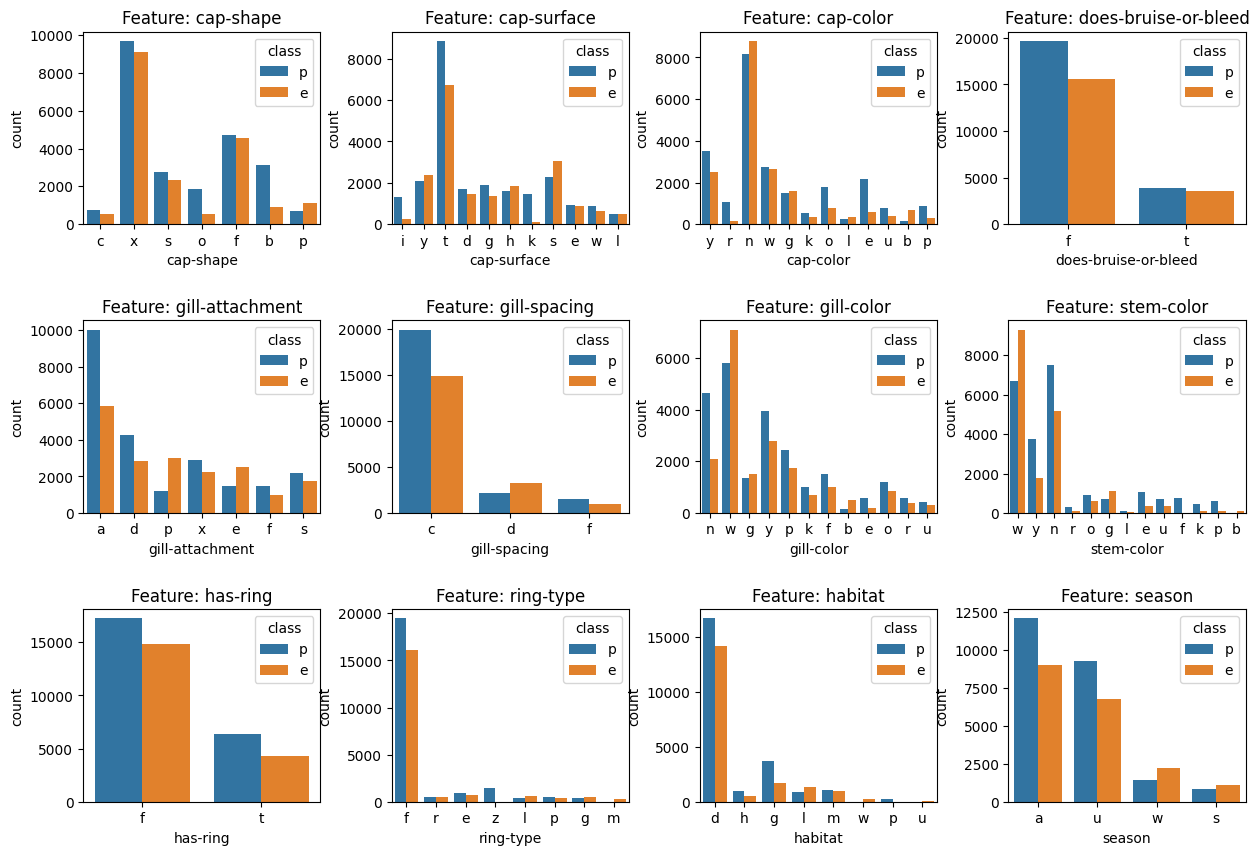

In [4]:
nrows = 3
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))
for idx, col in enumerate(feature_col_cat):
    row, col_idx = divmod(idx, ncols)
    ax = axes[row, col_idx]
    ax.set_title(f"Feature: {col}")
    sns.countplot(x=col, hue='class', data=df_train, ax=ax)
plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()


In [5]:
#random classifier for 3.1
def random_classifier(X, P0, P1):
    n_samples = len(X)
    pred = np.random.choice([0, 1], size=n_samples, p=[P0, P1])
    return pred

N = len(y_train)
N0 = len(y_train[y_train == 0])
N1 = len(y_train[y_train == 1])
P0 = N0 / N
P1 = N1 / N
y_pred_ran = random_classifier(X_test, P0, P1)
print('Accuracy: ', accuracy_score(y_test, y_pred_ran))
print("F1_score:", f1_score(y_test, y_pred_ran))

Accuracy:  0.5120899514218656
F1_score: 0.5598936536851953


In [6]:
#nearest mean classifier for 3.1
def nearest_means_classifier(X, mean_p, mean_e):
    dist_p = np.linalg.norm(X - mean_p, axis=1)
    dist_e = np.linalg.norm(X - mean_e, axis=1)
    pred = np.where(dist_p < dist_e, 1, 0)
    return pred

mean_p = X_train[y_train == 1].mean(axis=0)
mean_e = X_train[y_train == 0].mean(axis=0)
y_pred_nearest = nearest_means_classifier(X_test, mean_p, mean_e)
print('Accuracy: ', accuracy_score(y_test, y_pred_nearest))
print("F1_score:", f1_score(y_test, y_pred_nearest))

Accuracy:  0.6014409693794007
F1_score: 0.6487396574947085


Accuracy: 0.72572457835271
F1_score: 0.7519376018166559


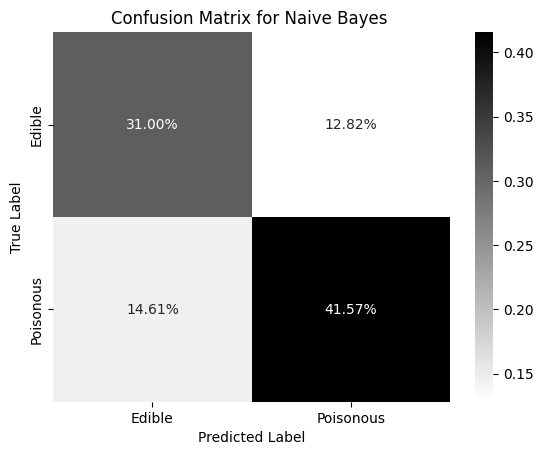

In [5]:
#Naive Bayes 3.2.3
nb = CategoricalNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_nb))
print('F1_score:', f1_score(y_test, y_pred_nb))

cm_nb = confusion_matrix(y_test, y_pred_nb)
x_axis_labels = ["Edible", "Poisonous"]
y_axis_labels = ["Edible", "Poisonous"]

sns.heatmap(cm_nb/np.sum(cm_nb), annot=True, fmt='.2%', cmap='binary', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Naive Bayes ')
plt.show()

Accuracy: 0.7890944817422629
F1_score: 0.8131708732230926


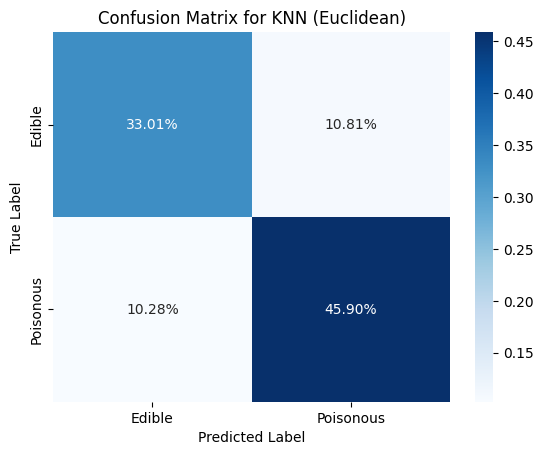

In [9]:
#KNN(Euclidean) 3.2.3
knn_euc = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean', n_jobs=1, n_neighbors=3)
knn_euc.fit(X_train, y_train)
y_pred_knn_2 = knn_euc.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_knn_2))
print('F1_score:', f1_score(y_test, y_pred_knn_2))

cm_knn_2 = confusion_matrix(y_test, y_pred_knn_2)
sns.heatmap(cm_knn_2/np.sum(cm_knn_2), annot=True, fmt='.2%', cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN (Euclidean)')
plt.show()

Accuracy: 0.8625075050488511
F1_score: 0.8783032996763128


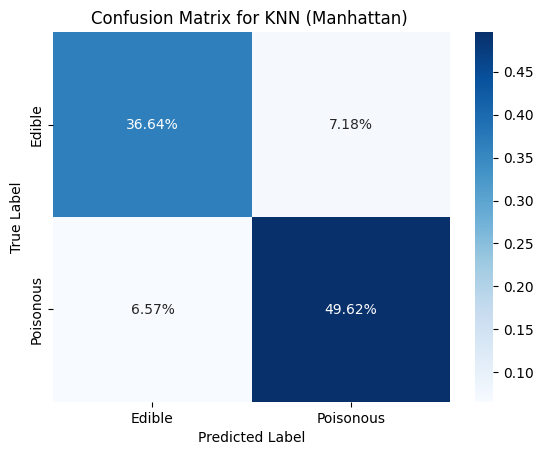

In [10]:
#KNN(Manhattan) 3.2.3
knn_man = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', n_jobs=1, n_neighbors=5)
knn_man.fit(X_train, y_train)
y_pred_knn_3 = knn_man.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred_knn_3))
print('F1_score:', f1_score(y_test, y_pred_knn_3))

cm_knn_3 = confusion_matrix(y_test, y_pred_knn_3)
sns.heatmap(cm_knn_3/np.sum(cm_knn_3), annot=True, fmt='.2%', cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN (Manhattan) ')
plt.show()

Feature Engineering

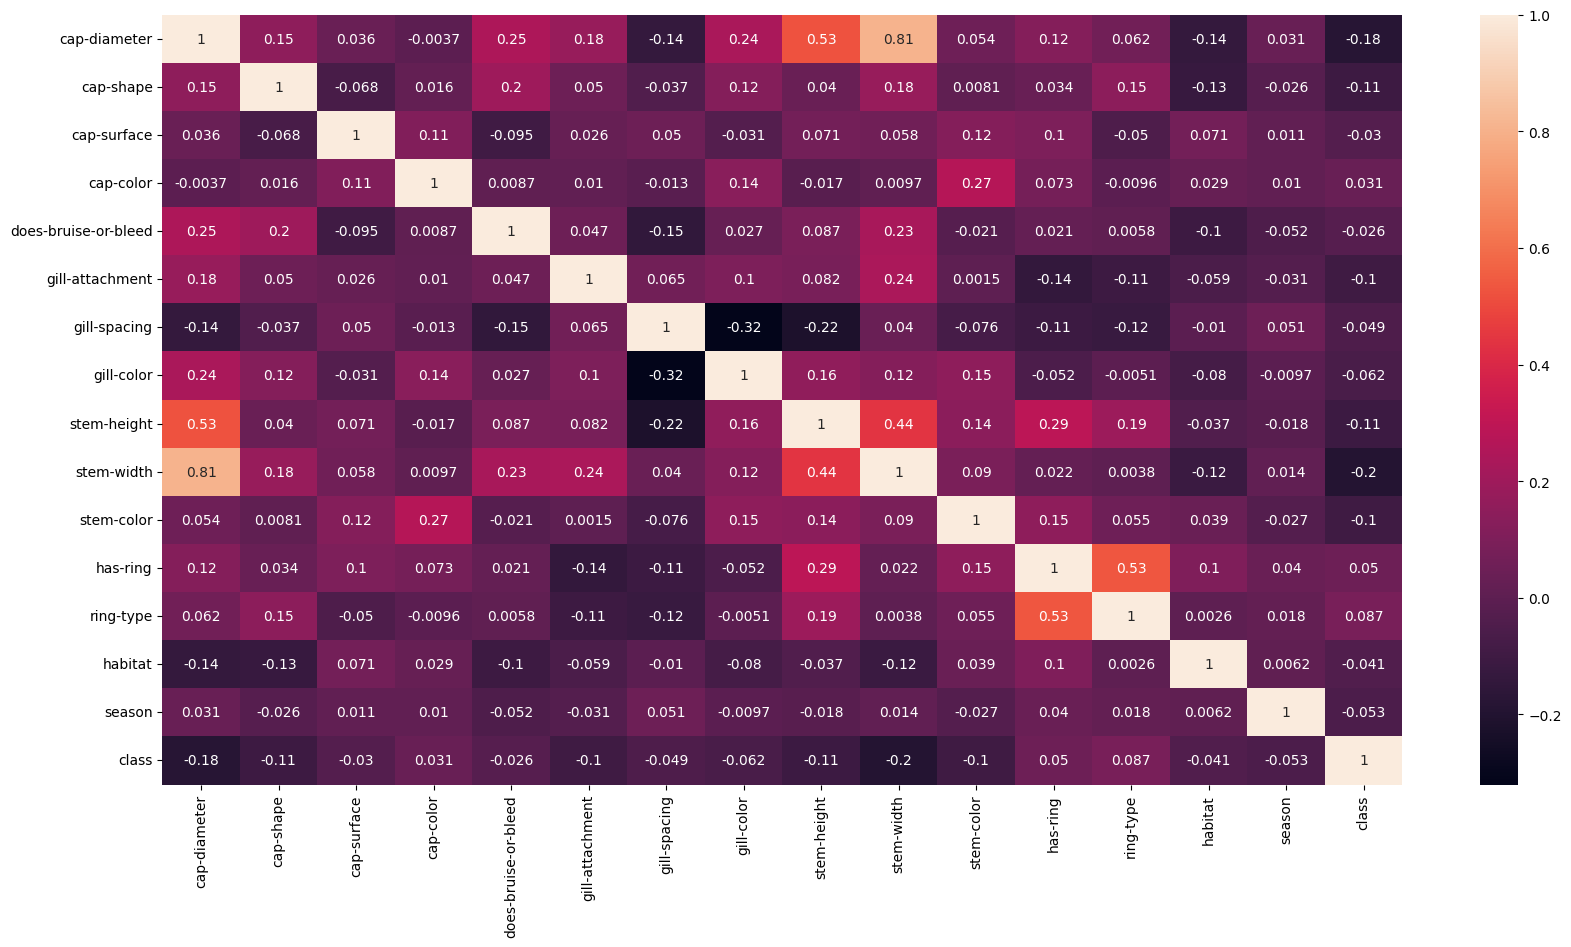

In [11]:
plt.figure(figsize=(20,10))
df_cor =pd.concat([X_train, y_train], axis=1)
corr = df_cor.corr()
sns.heatmap(corr, annot=True)
plt.show()

<AxesSubplot: >

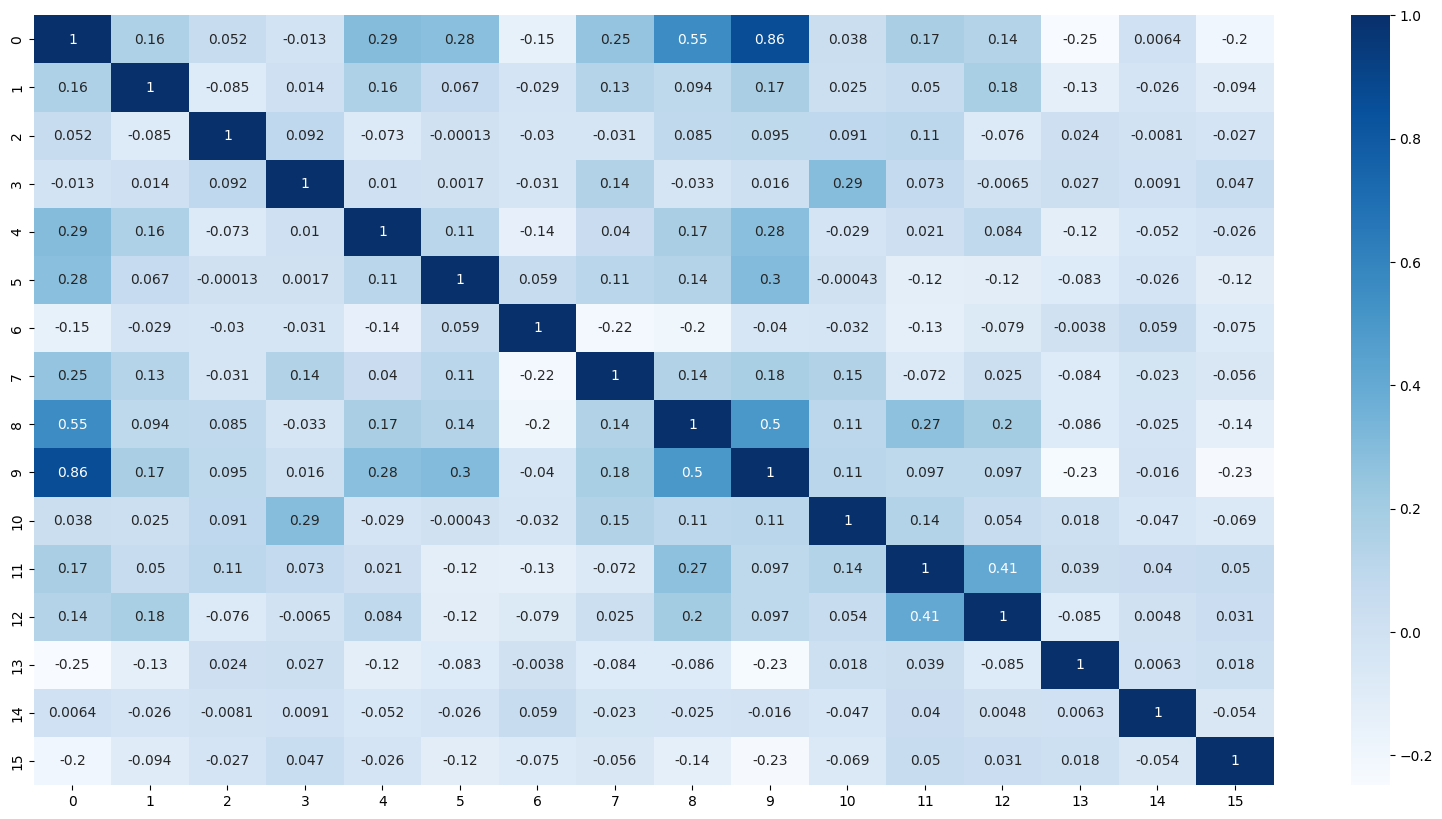

In [12]:
plt.figure(figsize=(20,10))
correlation_matrix, _ = spearmanr(df_cor)
sns.heatmap(correlation_matrix, annot=True, cmap=plt.cm.Blues)

In [9]:
#Feature Engineering 3.3.1
X_merge = df_train.drop('class', axis=1)
grouped_color = X_merge.groupby('stem-color')
grouped_ga = X_merge.groupby('gill-attachment')
grouped_rt = X_merge.groupby('ring-type')


# Calculate the min, max, and mean of the 'cap_diameter' column for each group
cap_diameter_min_scolor = grouped_color['cap-diameter'].min()
cap_diameter_max_scolor = grouped_color['cap-diameter'].max()
cap_diameter_mean_scolor = grouped_color['cap-diameter'].mean()
stem_height_min_scolor = grouped_color['stem-height'].min()
stem_height_max_scolor = grouped_color['stem-height'].max()
stem_height_mean_scolor = grouped_color['stem-height'].mean()
stem_width_min_scolor = grouped_color['stem-width'].min()
stem_width_max_scolor = grouped_color['stem-width'].max()
stem_width_mean_scolor = grouped_color['stem-width'].mean()

cap_diameter_max_ga = grouped_ga['cap-diameter'].max()
cap_diameter_min_ga = grouped_ga['cap-diameter'].min()
cap_diameter_mean_ga = grouped_ga['cap-diameter'].mean()
stem_height_min_ga = grouped_ga['stem-height'].min()
stem_height_max_ga = grouped_ga['stem-height'].max()
stem_height_mean_ga = grouped_ga['stem-height'].mean()
stem_width_min_ga = grouped_ga['stem-width'].min()
stem_width_max_ga = grouped_ga['stem-width'].max()
stem_width_mean_ga = grouped_ga['stem-width'].mean()

cap_diameter_min_rt = grouped_rt['cap-diameter'].min()
cap_diameter_max_rt = grouped_rt['cap-diameter'].max()
cap_diameter_mean_rt = grouped_rt['cap-diameter'].mean()
stem_height_min_rt = grouped_rt['stem-height'].min()
stem_height_max_rt = grouped_rt['stem-height'].max()
stem_height_mean_rt = grouped_rt['stem-height'].mean()
stem_width_min_rt = grouped_rt['stem-width'].min()
stem_width_max_rt = grouped_rt['stem-width'].max()
stem_width_mean_rt = grouped_rt['stem-width'].mean()


# Create new columns in the original DataFrame for the calculated statistics
X_merge['cap-diameter-min-stem-color'] = X_merge['stem-color'].map(cap_diameter_min_scolor)
X_merge['cap-diameter-max-stem-color'] = X_merge['stem-color'].map(cap_diameter_max_scolor)
X_merge['cap-diameter-mean-stem-color'] = X_merge['stem-color'].map(cap_diameter_mean_scolor)
X_merge['stem-height-min-stem-color'] = X_merge['stem-color'].map(stem_height_min_scolor)
X_merge['stem-height-max-stem-color'] = X_merge['stem-color'].map(stem_height_max_scolor)
X_merge['stem-height-mean-stem-color'] = X_merge['stem-color'].map(stem_height_mean_scolor)
X_merge['stem-width-min-stem-color'] = X_merge['stem-color'].map(stem_width_min_scolor)
X_merge['stem-width-max-stem-color'] = X_merge['stem-color'].map(stem_width_max_scolor)
X_merge['stem-width-mean-stem-color'] = X_merge['stem-color'].map(stem_width_mean_scolor)

X_merge['cap-diameter-min-gill-attachment'] = X_merge['gill-attachment'].map(cap_diameter_min_ga)
X_merge['cap-diameter-max-gill-attachment'] = X_merge['gill-attachment'].map(cap_diameter_max_ga)
X_merge['cap-diameter-mean-gill-attachment'] = X_merge['gill-attachment'].map(cap_diameter_mean_ga)
X_merge['stem-height-min-gill-attachment'] = X_merge['gill-attachment'].map(stem_height_min_ga)
X_merge['stem-height-max-gill-attachment'] = X_merge['gill-attachment'].map(stem_height_max_ga)
X_merge['stem-height-mean-gill-attachment'] = X_merge['gill-attachment'].map(stem_height_mean_ga)
X_merge['stem-width-min-gill-attachment'] = X_merge['gill-attachment'].map(stem_width_min_ga)
X_merge['stem-width-max-gill-attachment'] = X_merge['gill-attachment'].map(stem_width_max_ga)
X_merge['stem-width-mean-gill-attachment'] = X_merge['gill-attachment'].map(stem_width_mean_ga)

X_merge['cap-diameter-min-ring-type'] = X_merge['ring-type'].map(cap_diameter_min_rt)
X_merge['cap-diameter-max-ring-type'] = X_merge['ring-type'].map(cap_diameter_max_rt)
X_merge['cap-diameter-mean-ring-type'] = X_merge['ring-type'].map(cap_diameter_mean_rt)
X_merge['stem-height-min-ring-type'] = X_merge['ring-type'].map(stem_height_min_rt)
X_merge['stem-height-max-ring-type'] = X_merge['ring-type'].map(stem_height_max_rt)
X_merge['stem-height-mean-ring-type'] = X_merge['ring-type'].map(stem_height_mean_rt)
X_merge['stem-width-min-ring-type'] = X_merge['ring-type'].map(stem_width_min_rt)
X_merge['stem-width-max-ring-type'] = X_merge['ring-type'].map(stem_width_max_rt)
X_merge['stem-width-mean-ring-type'] = X_merge['ring-type'].map(stem_width_mean_rt)

# Drop categorical columns
X_merge = X_merge.drop(X_merge.select_dtypes(include='object').columns, axis=1)
X_merge.head()



,cap-diameter,stem-height,stem-width,cap-diameter-min-stem-color,cap-diameter-max-stem-color,cap-diameter-mean-stem-color,stem-height-min-stem-color,stem-height-max-stem-color,stem-height-mean-stem-color,stem-width-min-stem-color,...,stem-width-mean-gill-attachment,cap-diameter-min-ring-type,cap-diameter-max-ring-type,cap-diameter-mean-ring-type,stem-height-min-ring-type,stem-height-max-ring-type,stem-height-mean-ring-type,stem-width-min-ring-type,stem-width-max-ring-type,stem-width-mean-ring-type
0,4.98,6.04,6.21,0.44,25.60,7.324716,1.94,27.85,7.289947,0.52,...,8.369365,0.38,62.34,6.516415,0.00,24.63,6.080137,0.00,103.91,12.070090
1,2.84,5.66,3.55,0.38,20.12,5.054896,0.97,17.77,5.948165,0.56,...,8.369365,2.29,18.70,7.315311,2.83,17.77,7.614580,2.99,28.09,11.868608
2,11.44,7.03,25.29,0.47,59.46,6.997890,1.09,33.92,6.745491,0.77,...,8.369365,1.13,14.58,6.468878,2.78,27.85,8.567546,1.95,29.73,10.935396
3,8.77,4.44,13.61,1.84,20.91,6.948825,3.88,7.54,5.112924,4.76,...,11.894995,0.38,62.34,6.516415,0.00,24.63,6.080137,0.00,103.91,12.070090
4,7.55,8.41,18.44,0.38,20.12,5.054896,0.97,17.77,5.948165,0.56,...,24.284523,0.38,62.34,6.516415,0.00,24.63,6.080137,0.00,103.91,12.070090


In [7]:
#Feature Engineering 3.3.1
X_merge_test = df_test.drop('class', axis=1)
grouped_color_t = X_merge_test.groupby('stem-color')
grouped_ga_t = X_merge_test.groupby('gill-attachment')
grouped_rt_t = X_merge_test.groupby('ring-type')

# Calculate the min, max, and mean of the 'cap_diameter' column for each group
cap_diameter_min_sc_t = grouped_color_t['cap-diameter'].min()
cap_diameter_max_sc_t = grouped_color_t['cap-diameter'].max()
cap_diameter_mean_sc_t = grouped_color_t['cap-diameter'].mean()
stem_height_max_sc_t = grouped_color_t['stem-height'].max()
stem_height_min_sc_t = grouped_color_t['stem-height'].min()
stem_height_mean_sc_t = grouped_color_t['stem-height'].mean()
stem_width_min_sc_t = grouped_color_t['stem-width'].min()
stem_width_max_sc_t = grouped_color_t['stem-width'].max()
stem_width_mean_sc_t = grouped_color_t['stem-width'].mean()

cap_diameter_min_ga_t = grouped_ga_t['cap-diameter'].min()
cap_diameter_max_ga_t = grouped_ga_t['cap-diameter'].max()
cap_diameter_mean_ga_t = grouped_ga_t['cap-diameter'].mean()
stem_height_min_ga_t = grouped_ga_t['stem-height'].min()
stem_height_max_ga_t = grouped_ga_t['stem-height'].max()
stem_height_mean_ga_t = grouped_ga_t['stem-height'].mean()
stem_width_min_ga_t = grouped_ga_t['stem-width'].min()
stem_width_max_ga_t = grouped_ga_t['stem-width'].max()
stem_width_mean_ga_t = grouped_ga_t['stem-width'].mean()

cap_diameter_min_rt_t = grouped_rt_t['cap-diameter'].min()
cap_diameter_max_rt_t = grouped_rt_t['cap-diameter'].max()
cap_diameter_mean_rt_t = grouped_rt_t['cap-diameter'].mean()
stem_height_min_rt_t = grouped_rt_t['stem-height'].min()
stem_height_max_rt_t = grouped_rt_t['stem-height'].max()
stem_height_mean_rt_t = grouped_rt_t['stem-height'].mean()
stem_width_min_rt_t = grouped_rt_t['stem-width'].min()
stem_width_max_rt_t = grouped_rt_t['stem-width'].max()
stem_width_mean_rt_t = grouped_rt_t['stem-width'].mean()


# Create new columns in the original DataFrame for the calculated statistics
X_merge_test['cap-diameter-min-stem-color'] = X_merge_test['stem-color'].map(cap_diameter_min_sc_t)
X_merge_test['cap-diameter-max-stem-color'] = X_merge_test['stem-color'].map(cap_diameter_max_sc_t)
X_merge_test['cap-diameter-mean-stem-color'] = X_merge_test['stem-color'].map(cap_diameter_mean_sc_t)
X_merge_test['stem-height-min-stem-color'] = X_merge_test['stem-color'].map(stem_height_min_sc_t)
X_merge_test['stem-height-max-stem-color'] = X_merge_test['stem-color'].map(stem_height_max_sc_t)
X_merge_test['stem-height-mean-stem-color'] = X_merge_test['stem-color'].map(stem_height_mean_sc_t)
X_merge_test['stem-width-min-stem-color'] = X_merge_test['stem-color'].map(stem_width_min_sc_t)
X_merge_test['stem-width-max-stem-color'] = X_merge_test['stem-color'].map(stem_width_max_sc_t)
X_merge_test['stem-width-mean-stem-color'] = X_merge_test['stem-color'].map(stem_width_mean_sc_t)

X_merge_test['cap-diameter-min-gill-attachment'] = X_merge_test['gill-attachment'].map(cap_diameter_min_ga_t)
X_merge_test['cap-diameter-max-gill-attachment'] = X_merge_test['gill-attachment'].map(cap_diameter_max_ga_t)
X_merge_test['cap-diameter-mean-gill-attachment'] = X_merge_test['gill-attachment'].map(cap_diameter_mean_ga_t) 
X_merge_test['stem-height-min-gill-attachment'] = X_merge_test['gill-attachment'].map(stem_height_min_ga_t)
X_merge_test['stem-height-max-gill-attachment'] = X_merge_test['gill-attachment'].map(stem_height_max_ga_t)
X_merge_test['stem-height-mean-gill-attachment'] = X_merge_test['gill-attachment'].map(stem_height_mean_ga_t)
X_merge_test['stem-width-min-gill-attachment'] = X_merge_test['gill-attachment'].map(stem_width_min_ga_t)
X_merge_test['stem-width-max-gill-attachment'] = X_merge_test['gill-attachment'].map(stem_width_max_ga_t)
X_merge_test['stem-width-mean-gill-attachment'] = X_merge_test['gill-attachment'].map(stem_width_mean_ga_t)

X_merge_test['cap-diameter-min-ring-type'] = X_merge_test['ring-type'].map(cap_diameter_min_rt_t)
X_merge_test['cap-diameter-max-ring-type'] = X_merge_test['ring-type'].map(cap_diameter_max_rt_t)
X_merge_test['cap-diameter-mean-ring-type'] = X_merge_test['ring-type'].map(cap_diameter_mean_rt_t)
X_merge_test['stem-height-min-ring-type'] = X_merge_test['ring-type'].map(stem_height_min_rt_t)
X_merge_test['stem-height-max-ring-type'] = X_merge_test['ring-type'].map(stem_height_max_rt_t)
X_merge_test['stem-height-mean-ring-type'] = X_merge_test['ring-type'].map(stem_height_mean_rt_t)
X_merge_test['stem-width-min-ring-type'] = X_merge_test['ring-type'].map(stem_width_min_rt_t)
X_merge_test['stem-width-max-ring-type'] = X_merge_test['ring-type'].map(stem_width_max_rt_t)
X_merge_test['stem-width-mean-ring-type'] = X_merge_test['ring-type'].map(stem_width_mean_rt_t)


# Drop categorical columns
X_merge_test = X_merge_test.drop(X_merge_test.select_dtypes(include='object').columns, axis=1)


Accuracy: 0.9773483980132089
F1_score: 0.9798514346749526


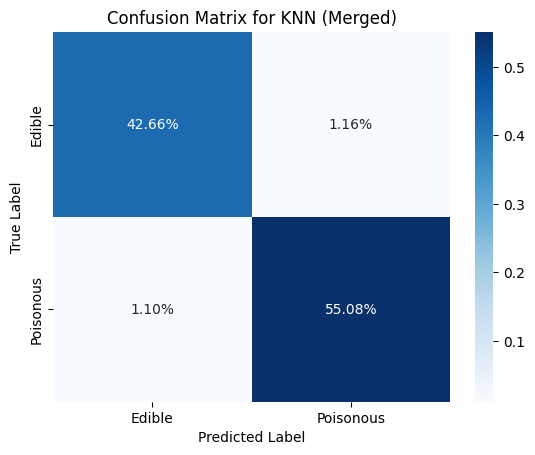

In [23]:
#KNN 3.3.3
knn_man_merge = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', n_jobs=1, n_neighbors=1)
knn_man.fit(X_merge, y_train)
y_pred_knn_4 = knn_man.predict(X_merge_test)

print('Accuracy:', accuracy_score(y_test, y_pred_knn_4))
print('F1_score:', f1_score(y_test, y_pred_knn_4))

cm_knn_4 = confusion_matrix(y_test, y_pred_knn_4)
sns.heatmap(cm_knn_4/np.sum(cm_knn_4), annot=True, fmt='.2%', cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN (Merged)')
plt.show()

Accuracy: 0.9993995960919164
F1_score: 0.9994659416419868


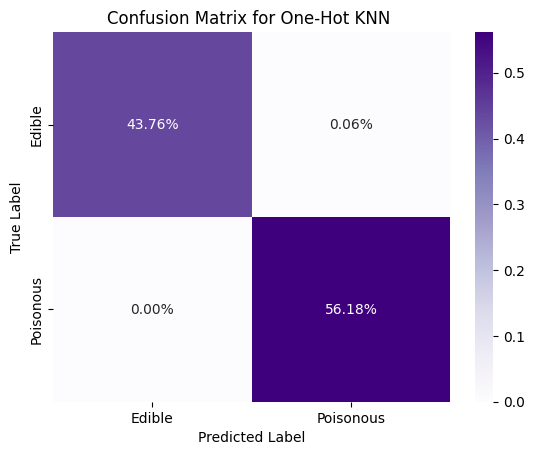

In [17]:
# KNN 3.2.3
X_dummy = pd.get_dummies(X_train, drop_first=True)
sc = StandardScaler()
X_std = sc.fit_transform(X_dummy)
X_test_dummy = pd.get_dummies(X_test, drop_first=True)
X_test_std = sc.transform(X_test_dummy)

knn_man_new = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', n_jobs=1, n_neighbors=1)
knn_man_new.fit(X_std, y_train)
y_pred_knn_s = knn_man_new.predict(X_test_std)
print('Accuracy:', accuracy_score(y_test, y_pred_knn_s))
print('F1_score:', f1_score(y_test, y_pred_knn_s))

cm_knn_s = confusion_matrix(y_test, y_pred_knn_s)
sns.heatmap(cm_knn_s/np.sum(cm_knn_s), annot=True, fmt='.2%', cmap='Purples', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for One-Hot KNN ')
plt.show()

Accuracy: 0.9994541782653785
F1_score: 0.9995142801632019


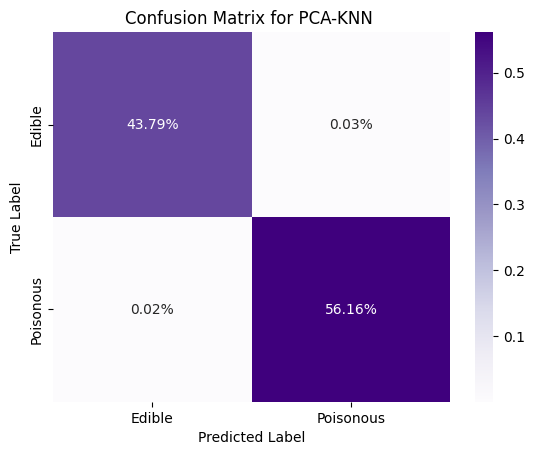

In [18]:
#PCA-KNN 3.2.3
sc = StandardScaler()
X_std = sc.fit_transform(X_dummy)
pca = PCA(n_components = 0.97)
X_pca = pca.fit_transform(X_std)
X_test_std = sc.transform(X_test_dummy)
X_test_pca = pca.transform(X_test_std)

knn_man_pca = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan',n_jobs=1, n_neighbors=1)
knn_man_pca.fit(X_pca, y_train)
y_pred_knn_pca = knn_man_pca.predict(X_test_pca)
print('Accuracy:', accuracy_score(y_test, y_pred_knn_pca))
print('F1_score:', f1_score(y_test, y_pred_knn_pca))

cm_knn_pca = confusion_matrix(y_test, y_pred_knn_pca)
sns.heatmap(cm_knn_pca/np.sum(cm_knn_pca), annot=True, fmt='.2%', cmap='Purples', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for PCA-KNN ')
plt.show()

In [17]:
#sanity check
# Create a pipeline
pca_knn_pipeline = make_pipeline(pca, knn_man_new)
# Perform 4-fold cross-validation
cv_scores = cross_val_score(pca_knn_pipeline, X_std, y_train, cv=4)

mean_cv_score = np.mean(cv_scores)
std_cv_score = np.std(cv_scores)

print(f'Mean CV score: {mean_cv_score}, Std Deviation: {std_cv_score}')

Mean CV score: 0.999274819874614, Std Deviation: 0.00016705877300795597


Accuracy: 0.8099448720048033
F1_score: 0.8318524241838903


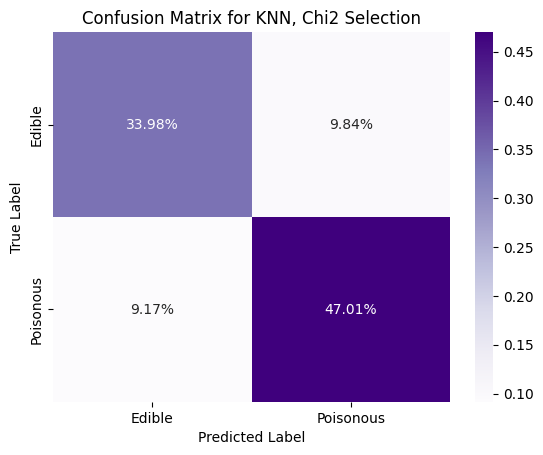

In [ ]:
#Feature Selection 3.3.6
chi2_features = SelectKBest(chi2,k=8).fit(X_train,y_train)
X_chi2 = chi2_features.transform(X_train)
X_chi2_test = chi2_features.transform(X_test)
chi2_features.get_feature_names_out()

knn_man_chi2 = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='manhattan', n_jobs=1, n_neighbors=1)
knn_man_new.fit(X_chi2, y_train)
y_pred_knn_chi2 = knn_man_new.predict(X_chi2_test)
print('Accuracy:', accuracy_score(y_test, y_pred_knn_chi2))
print('F1_score:', f1_score(y_test, y_pred_knn_chi2))

cm_knn_chi2 = confusion_matrix(y_test, y_pred_knn_chi2)
sns.heatmap(cm_knn_chi2/np.sum(cm_knn_chi2), annot=True, fmt='.2%', cmap='Purples', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for KNN, Chi2 Selection')
plt.show()

Accuracy: 0.9960700835107253
F1_score: 0.9965119658947776


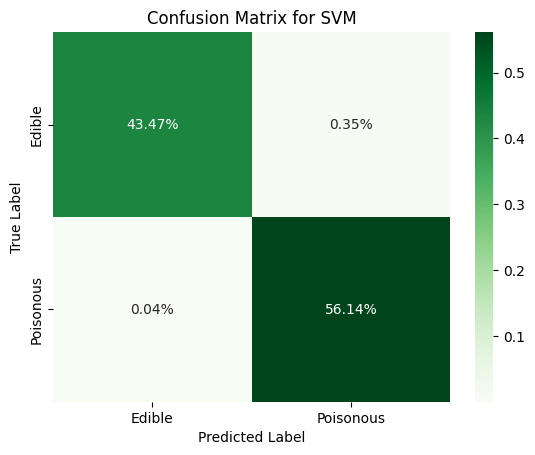

In [80]:
#SVM 3.1.2
svm = SVC(kernel='rbf', C=100)

# Train the model using the training data
svm.fit(X_std, y_train)
y_svm = svm.predict(X_test_std)
print('Accuracy:', accuracy_score(y_test, y_svm))
print('F1_score:', f1_score(y_test, y_svm))

cm_svm = confusion_matrix(y_test, y_svm)
sns.heatmap(cm_svm/np.sum(cm_svm), annot=True, fmt='.2%', cmap='Greens', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM')
plt.show()

Accuracy: 0.7132252606298782
F1_score: 0.7545089243995887


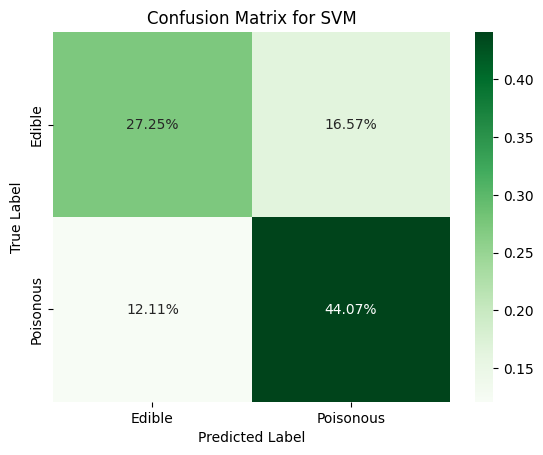

In [12]:
#3.2.2 SVM
svm_cat = SVC(kernel='rbf', C=100)

# Train the model using the training data
svm_cat.fit(X_train, y_train)
y_svm_cat = svm_cat.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_svm_cat))
print('F1_score:', f1_score(y_test, y_svm_cat))

cm_svm_c = confusion_matrix(y_test, y_svm_cat)
sns.heatmap(cm_svm_c/np.sum(cm_svm_c), annot=True, fmt='.2%', cmap='Greens', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM')
plt.show()

Accuracy: 0.8069974346378472
F1_score: 0.8273774653388011


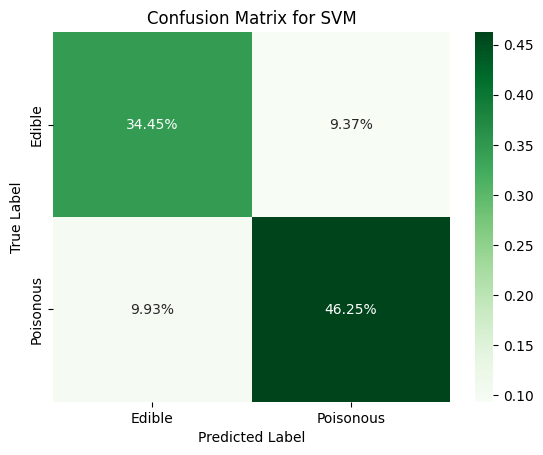

In [11]:
#3.3.2 SVM
svm_merge = SVC(kernel='rbf', C=100)

# Train the model using the training data
svm_merge.fit(X_merge, y_train)
y_svm_merge = svm_merge.predict(X_merge_test)
print('Accuracy:', accuracy_score(y_test, y_svm_merge))
print('F1_score:', f1_score(y_test, y_svm_merge))

cm_svm_m = confusion_matrix(y_test, y_svm_merge)
sns.heatmap(cm_svm_m/np.sum(cm_svm_m), annot=True, fmt='.2%', cmap='Greens', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SVM')
plt.show()

In [38]:
#random system for one-hot encoding
y_one_hot_ran = random_classifier(X_test_std, P0, P1)
print('Accuracy:', accuracy_score(y_test, y_one_hot_ran))
print('F1_score:', f1_score(y_test, y_one_hot_ran))

#trivial system for one-hot encoding
mean_p_oh = X_std[y_train == 1].mean(axis=0)
mean_e_oh = X_std[y_train == 0].mean(axis=0)
y_one_hot_nearest = nearest_means_classifier(X_test_std, mean_p_oh, mean_e_oh)
print('Accuracy: ', accuracy_score(y_test, y_one_hot_nearest))
print("F1_score:", f1_score(y_test, y_one_hot_nearest))

Accuracy: 0.5096883357895311
F1_score: 0.5585098540325355
Accuracy:  0.6168331422957262
F1_score: 0.6536412078152753


Epoch 1/50
4275/4275 [==============================] - 5s 977us/step - loss: 1.5122 - accuracy: 0.6072
Epoch 2/50
4275/4275 [==============================] - 4s 892us/step - loss: 0.8123 - accuracy: 0.6585
Epoch 3/50
4275/4275 [==============================] - 4s 918us/step - loss: 0.6149 - accuracy: 0.7016
Epoch 4/50
4275/4275 [==============================] - 4s 902us/step - loss: 0.5227 - accuracy: 0.7353
Epoch 5/50
4275/4275 [==============================] - 4s 909us/step - loss: 0.4590 - accuracy: 0.7766
Epoch 6/50
4275/4275 [==============================] - 4s 923us/step - loss: 0.3999 - accuracy: 0.8105
Epoch 7/50
4275/4275 [==============================] - 4s 898us/step - loss: 0.3599 - accuracy: 0.8341
Epoch 8/50
4275/4275 [==============================] - 4s 964us/step - loss: 0.3247 - accuracy: 0.8554
Epoch 9/50
4275/4275 [==============================] - 4s 912us/step - loss: 0.3043 - accuracy: 0.8651
Epoch 10/50
4275/4275 [==============================] - 4s 922u

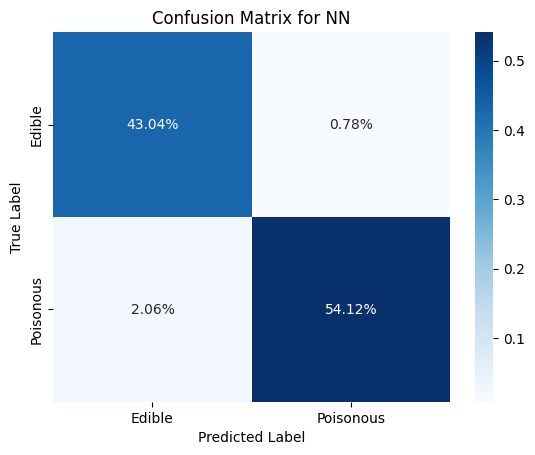

In [58]:
#Neural Network 3.2.4
NN = Sequential()
NN.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
NN.add(Dense(64, activation='relu'))
NN.add(Dense(1, activation='sigmoid'))
NN.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
NN.fit(X_train, y_train, batch_size=10, epochs=50)

y_nn = NN.predict(X_test)
y_nn = y_nn > 0.5
y_nn = y_nn.astype(int)


print('Accuracy:', accuracy_score(y_test, y_nn))
print('F1_score:', f1_score(y_test, y_nn))

cm_nn = confusion_matrix(y_test, y_nn)
sns.heatmap(cm_nn/np.sum(cm_nn), annot=True, fmt='.2%', cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for NN')
plt.show()


Epoch 1/50
4275/4275 [==============================] - 5s 1ms/step - loss: 0.5705 - accuracy: 0.7079
Epoch 2/50
4275/4275 [==============================] - 5s 1ms/step - loss: 0.3985 - accuracy: 0.8059
Epoch 3/50
4275/4275 [==============================] - 8s 2ms/step - loss: 0.3136 - accuracy: 0.8540
Epoch 4/50
4275/4275 [==============================] - 5s 1ms/step - loss: 0.2654 - accuracy: 0.8759
Epoch 5/50
4275/4275 [==============================] - 5s 1ms/step - loss: 0.2379 - accuracy: 0.8894
Epoch 6/50
4275/4275 [==============================] - 5s 1ms/step - loss: 0.2222 - accuracy: 0.8981
Epoch 7/50
4275/4275 [==============================] - 6s 1ms/step - loss: 0.2083 - accuracy: 0.9054
Epoch 8/50
4275/4275 [==============================] - 6s 1ms/step - loss: 0.1956 - accuracy: 0.9119
Epoch 9/50
4275/4275 [==============================] - 9s 2ms/step - loss: 0.1880 - accuracy: 0.9166
Epoch 10/50
4275/4275 [==============================] - 8s 2ms/step - loss: 0.176

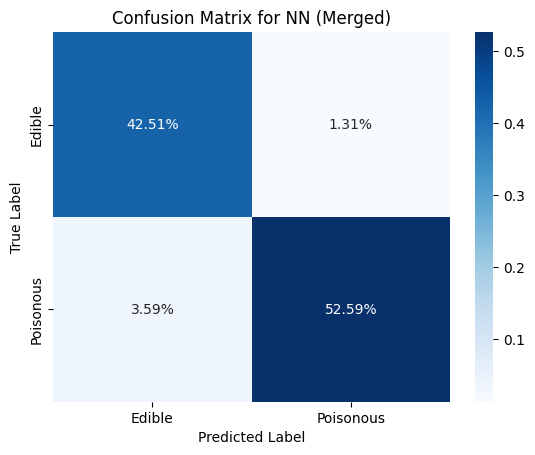

In [78]:
#Neural Network 3.3.4
NN_merge = Sequential()
NN_merge.add(Dense(64, activation='relu', input_dim=X_merge.shape[1]))
NN_merge.add(Dense(64, activation='relu'))
NN_merge.add(Dense(1, activation='sigmoid'))
NN_merge.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
NN_merge.fit(X_merge, y_train, batch_size=10, epochs=50)

y_nn_merge = NN_merge.predict(X_merge_test)
y_nn_merge = y_nn_merge > 0.5
y_nn_merge = y_nn_merge.astype(int)


print('Accuracy:', accuracy_score(y_test, y_nn_merge))
print('F1_score:', f1_score(y_test, y_nn_merge))

cm_nn = confusion_matrix(y_test, y_nn_merge)
sns.heatmap(cm_nn/np.sum(cm_nn), annot=True, fmt='.2%', cmap='Blues', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for NN (Merged)')
plt.show()

Accuracy: 0.6149227662245511
F1_score: 0.6910985594815885


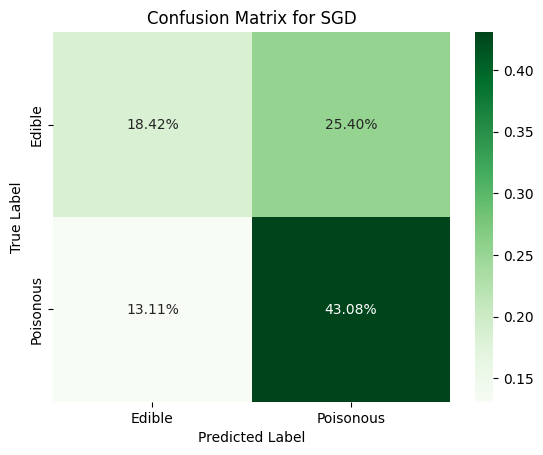

In [20]:
#3.1.4 Non-probabilistic classifiers
sgd = SGDClassifier(loss='hinge', penalty='l2', alpha=0.0001, max_iter=1000, tol=1e-3, random_state=0)
sgd.fit(X_std, y_train)
y_sgd = sgd.predict(X_test_std)
print('Accuracy:', accuracy_score(y_test, y_sgd))
print('F1_score:', f1_score(y_test, y_sgd))

cm_sgd = confusion_matrix(y_test, y_sgd)
sns.heatmap(cm_sgd/np.sum(cm_sgd), annot=True, fmt='.2%', cmap='Greens', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for SGD')
plt.show()

Accuracy: 0.9893018940014191
F1_score: 0.9905314009661836


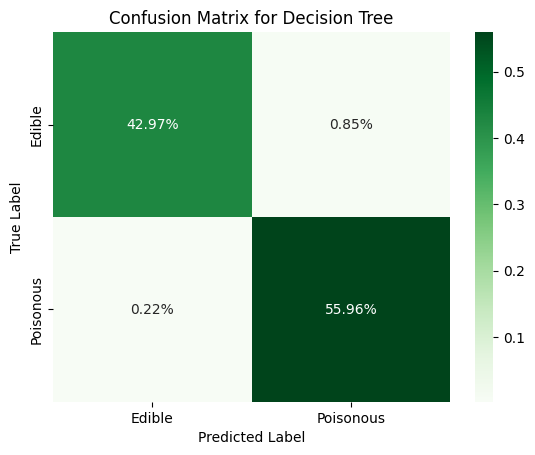

In [29]:
#Decision Tree 3.2.5
tree = DecisionTreeClassifier(criterion='entropy', max_depth=20, random_state=0)
tree.fit(X_train, y_train)
y_tree = tree.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_tree))
print('F1_score:', f1_score(y_test, y_tree))

cm_tree = confusion_matrix(y_test, y_tree)
sns.heatmap(cm_tree/np.sum(cm_tree), annot=True, fmt='.2%', cmap='Greens', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree')
plt.show()


Accuracy: 0.889525680912614
F1_score: 0.9039027632703446


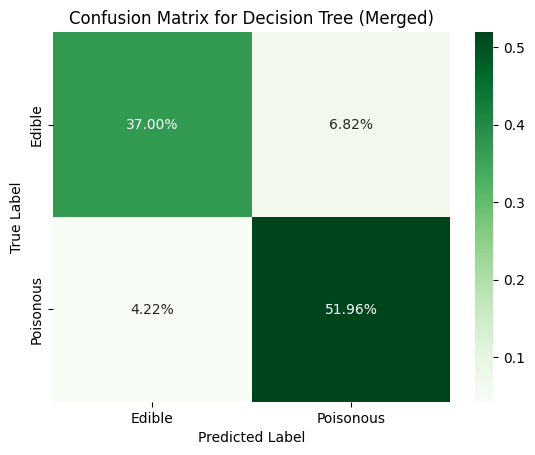

In [42]:
#Decision Tree 3.3.5
tree_merge = DecisionTreeClassifier(criterion='entropy', max_depth=15, random_state=0)
tree_merge.fit(X_merge, y_train)
y_tree_merge = tree_merge.predict(X_merge_test)
print('Accuracy:', accuracy_score(y_test, y_tree_merge))
print('F1_score:', f1_score(y_test, y_tree_merge))

cm_tree_m = confusion_matrix(y_test, y_tree_merge)
sns.heatmap(cm_tree_m/np.sum(cm_tree_m), annot=True, fmt='.2%', cmap='Greens', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Decision Tree (Merged)')
plt.show()
